<a href="https://colab.research.google.com/github/BarnaP02/Deep-Learning-NHF/blob/main/BirdCLEF24_NHZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Open the notebook in Google Colab:**
   
   [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/BarnaP02/Deep-Learning-NHF/blob/4266bea0f3fd50093292e726b95d2c151ad7ac28/BirdCLEF24_NHZ.ipynb)


# Import Libraries

In [1]:
!pip install keras-cv
!pip install tensorflow-io

In [2]:
import os
os.environ["KERAS_BACKEND"] = "jax"  # "jax" or "tensorflow" or "torch"

import keras_cv
import keras
import keras.backend as K
import tensorflow as tf
import tensorflow_io as tfio
#!pip install tensorflow-io as tfio

import numpy as np
import pandas as pd

from glob import glob
from tqdm import tqdm

import librosa
import IPython.display as ipd
import librosa.display as lid

import matplotlib.pyplot as plt
import matplotlib as mpl

# cmap = mpl.cm.get_cmap('coolwarm')
cmap = mpl.colormaps.get_cmap('coolwarm')
# or simply:
# cmap = mpl.colormaps['coolwarm']

/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutex6unlockEv']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZN3tsl7strings13safe_strtou64ESt17basic_string_viewIcSt11char_traitsIcEEPm']
  warnings.warn(

# Kaggle Setup and Data Download

In [3]:
from google.colab import drive
import os
import pandas as pd

try:
    print("=" * 60)
    print("BIRDCLEF 2024 - DATASET SETUP FROM GOOGLE DRIVE")
    print("=" * 60)

    # Mount Google Drive
    print("\n📁 Mounting Google Drive...")
    drive.mount('/content/drive')
    print("✓ Drive mounted successfully")

    # Set path to dataset in Drive
    # ADJUST THIS PATH based on where you uploaded the dataset
    DRIVE_DATASET_PATH = '/content/drive/MyDrive/Deep_Learning_NHF/birdclef-2024'

    # Check if dataset exists
    print(f"\n🔍 Looking for dataset at: {DRIVE_DATASET_PATH}")

    if not os.path.exists(DRIVE_DATASET_PATH):
        print(f"\n❌ Dataset not found at: {DRIVE_DATASET_PATH}")
        print("\n📤 Please ensure your dataset is uploaded to Google Drive at:")
        print("   My Drive/birdclef-2024/")
        print("\n   Expected structure:")
        print("   birdclef-2024/")
        print("   ├── train_audio/")
        print("   ├── train_metadata.csv")
        print("   └── ...")
        raise FileNotFoundError("Dataset not found in Google Drive")

    print(f"✓ Dataset folder found!")

    # Verify required files/folders
    train_audio_path = os.path.join(DRIVE_DATASET_PATH, 'train_audio')
    metadata_path = os.path.join(DRIVE_DATASET_PATH, 'train_metadata.csv')

    if not os.path.exists(train_audio_path):
        raise FileNotFoundError(f"train_audio folder not found at: {train_audio_path}")

    if not os.path.exists(metadata_path):
        raise FileNotFoundError(f"train_metadata.csv not found at: {metadata_path}")

    print("✓ train_audio folder found")
    print("✓ train_metadata.csv found")

    # Load metadata
    print("\n📊 Loading metadata...")
    df = pd.read_csv(metadata_path)

    # Get species list from actual folders
    species_list = sorted([d for d in os.listdir(train_audio_path)
                          if os.path.isdir(os.path.join(train_audio_path, d))])

    print(f"\n✅ Dataset loaded successfully!")
    print(f"   📝 Total samples in metadata: {len(df)}")
    print(f"   🐦 Species folders found: {len(species_list)}")

    if len(species_list) > 0:
        print(f"   🔤 First 5 species: {species_list[:5]}")
        print(f"   🔤 Last 5 species: {species_list[-5:]}")

    # Set BASE_PATH for the rest of the notebook
    BASE_PATH = DRIVE_DATASET_PATH

    print(f"\n✓ BASE_PATH set to: {BASE_PATH}")
    print("=" * 60)
    print("\n🚀 Ready to proceed with data exploration and training!")

except Exception as e:
    print(f"\n❌ Error: {e}")
    import traceback
    traceback.print_exc()
    print("\n💡 Troubleshooting:")
    print("1. Make sure your dataset is fully uploaded to Google Drive")
    print("2. Check the path matches where you uploaded (default: My Drive/birdclef-2024/)")
    print("3. Verify the folder structure includes train_audio/ and train_metadata.csv")

BIRDCLEF 2024 - DATASET SETUP FROM GOOGLE DRIVE

📁 Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Drive mounted successfully

🔍 Looking for dataset at: /content/drive/MyDrive/Deep_Learning_NHF/birdclef-2024
✓ Dataset folder found!
✓ train_audio folder found
✓ train_metadata.csv found

📊 Loading metadata...

✅ Dataset loaded successfully!
   📝 Total samples in metadata: 24459
   🐦 Species folders found: 182
   🔤 First 5 species: ['asbfly', 'ashdro1', 'ashpri1', 'ashwoo2', 'asikoe2']
   🔤 Last 5 species: ['woosan', 'wynlau1', 'yebbab1', 'yebbul3', 'zitcis1']

✓ BASE_PATH set to: /content/drive/MyDrive/Deep_Learning_NHF/birdclef-2024

🚀 Ready to proceed with data exploration and training!


# Library Version

In [4]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasCV:", keras_cv.__version__)

TensorFlow: 2.19.0
Keras: 3.10.0
KerasCV: 0.9.0


# Configuration

In [5]:
# This command will delete all .ogg files in the current directory.
# Please be careful when running this command as it will permanently delete the files.
## !rmdir birdclef-2024/train_audio/*

In [6]:
class CFG:
    seed = 42

    # Input image size and batch size
    img_size = [128, 384]
    batch_size = 64

    # Audio duration, sample rate, and length
    duration = 15 # second
    sample_rate = 32000
    audio_len = duration*sample_rate

    # STFT parameters
    nfft = 2028
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000

    # Number of epochs, model name
    epochs = 10
    preset = 'efficientnetv2_b2_imagenet'

    # Data augmentation parameters
    augment=True


# Load Class Names
Initialize class names after data is downloaded.

In [7]:
CFG.class_names = sorted(os.listdir(f'{BASE_PATH}/train_audio/'))
CFG.num_classes = len(CFG.class_names)
CFG.class_labels = list(range(CFG.num_classes))
CFG.label2name = dict(zip(CFG.class_labels, CFG.class_names))
CFG.name2label = {v:k for k,v in CFG.label2name.items()}

print(f"Loaded {CFG.num_classes} bird species")

Loaded 182 bird species


# Reproducibility

In [8]:
tf.keras.utils.set_random_seed(CFG.seed)

# Dataset Path

In [9]:
# BASE_PATH is already set by the setup cell above
# If running cells out of order, uncomment below:
# BASE_PATH = '/content/drive/MyDrive/birdclef-2024'

print(f"Using dataset from: {BASE_PATH}")

Using dataset from: /content/drive/MyDrive/Deep_Learning_NHF/birdclef-2024


# Meta Data

In [10]:
df = pd.read_csv(f'{BASE_PATH}/train_metadata.csv')
df['filepath'] = BASE_PATH + '/train_audio/' + df.filename
df['target'] = df.primary_label.map(CFG.name2label)

# IMPORTANT: Filter to only downloaded species
df = df[df['primary_label'].isin(CFG.class_names)].reset_index(drop=True)

df['filename'] = df.filepath.map(lambda x: x.split('/')[-1])
df['xc_id'] = df.filepath.map(lambda x: x.split('/')[-1].split('.')[0])

print(f"Total samples after filtering: {len(df)}")
print(f"Species distribution:\n{df['primary_label'].value_counts().head(10)}")

# Display rwos
df.head(2)

Total samples after filtering: 24459
Species distribution:
primary_label
bcnher     500
barswa     500
bkwsti     500
blrwar1    500
comsan     500
comgre     500
eaywag1    500
commoo3    500
comkin1    500
comros     500
Name: count, dtype: int64


primary_label secondary_labels      type  latitude  longitude  \
0        asbfly               []  ['call']   39.2297   118.1987   
1        asbfly               []  ['song']   51.4030   104.6401   

      scientific_name             common_name            author  \
0  Muscicapa dauurica  Asian Brown Flycatcher    Matt Slaymaker   
1  Muscicapa dauurica  Asian Brown Flycatcher  Magnus Hellström   

                                             license  rating  \
0  Creative Commons Attribution-NonCommercial-Sha...     5.0   
1  Creative Commons Attribution-NonCommercial-Sha...     2.5   

                                 url      filename  \
0  https://www.xeno-canto.org/134896  XC134896.ogg   
1  https://www.xeno-canto.org/164848  XC164848.ogg   

                                            filepath  target     xc_id  
0  /content/drive/MyDrive/Deep_Learning_NHF/birdc...       0  XC134896  
1  /content/drive/MyDrive/Deep_Learning_NHF/birdc...       0  XC164848

# Utility

In [11]:
def load_audio(filepath):
    audio, sr = librosa.load(filepath)
    return audio, sr

def get_spectrogram(audio):
    spec = librosa.feature.melspectrogram(y=audio,
                                   sr=CFG.sample_rate,
                                   n_mels=256,
                                   n_fft=2048,
                                   hop_length=512,
                                   fmax=CFG.fmax,
                                   fmin=CFG.fmin,
                                   )
    spec = librosa.power_to_db(spec, ref=1.0)
    min_ = spec.min()
    max_ = spec.max()
    if max_ != min_:
        spec = (spec - min_)/(max_ - min_)
    return spec

def display_audio(row):
    # Caption for viz
    caption = f'Id: {row.filename} | Name: {row.common_name} | Sci.Name: {row.scientific_name} | Rating: {row.rating}'
    # Read audio file
    audio, sr = load_audio(row.filepath)
    # Keep fixed length audio
    audio = audio[:CFG.audio_len]
    # Spectrogram from audio
    spec = get_spectrogram(audio)
    # Display audio
    print("# Audio:")
    display(ipd.Audio(audio, rate=CFG.sample_rate))
    print('# Visualization:')
    fig, ax = plt.subplots(2, 1, figsize=(12, 2*3), sharex=True, tight_layout=True)
    fig.suptitle(caption)
    # Waveplot
    lid.waveshow(audio,
                 sr=CFG.sample_rate,
                 ax=ax[0],
                 color= cmap(0.1))
    # Specplot
    lid.specshow(spec,
                 sr = CFG.sample_rate,
                 hop_length=512,
                 n_fft=2048,
                 fmin=CFG.fmin,
                 fmax=CFG.fmax,
                 x_axis = 'time',
                 y_axis = 'mel',
                 cmap = 'coolwarm',
                 ax=ax[1])
    ax[0].set_xlabel('');
    fig.show()

# Sample 1

# Audio:


# Visualization:


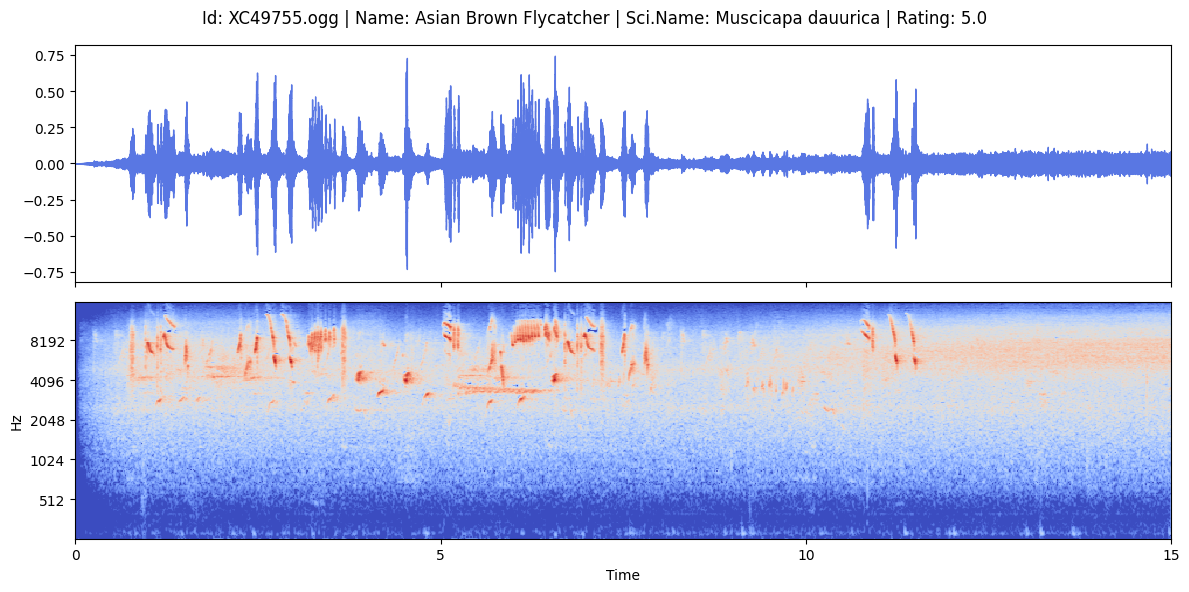

In [12]:
row = df.iloc[35]

# Display audio
display_audio(row)

# Sample 2

# Audio:


# Visualization:


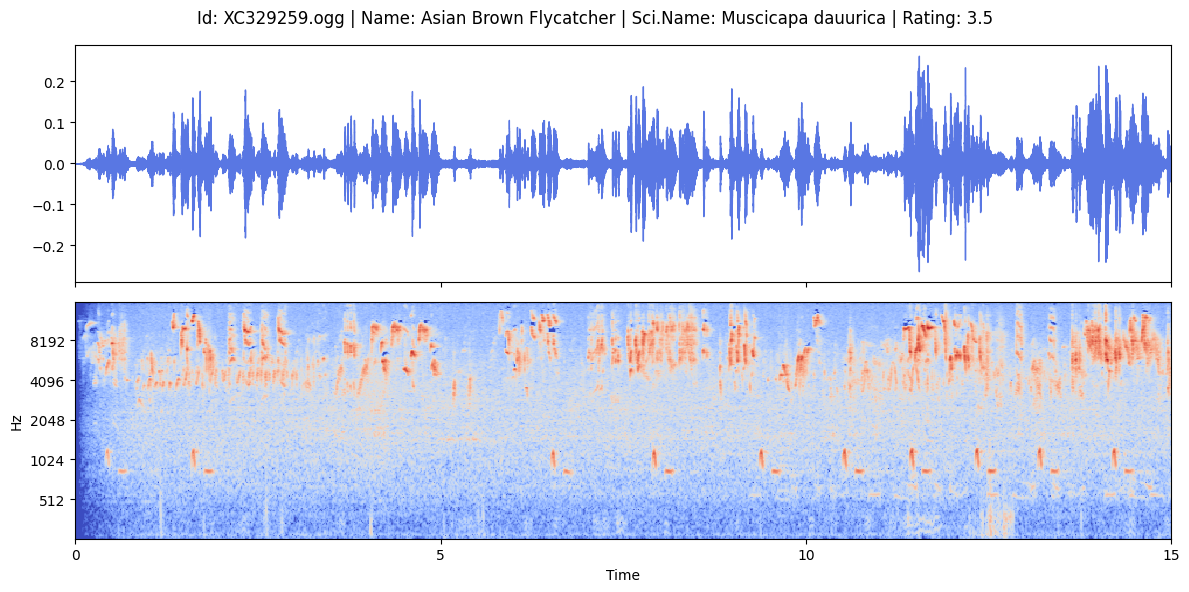

In [13]:
row = df.iloc[16]

# Display audio
display_audio(row)

# Sample 3

# Audio:


# Visualization:


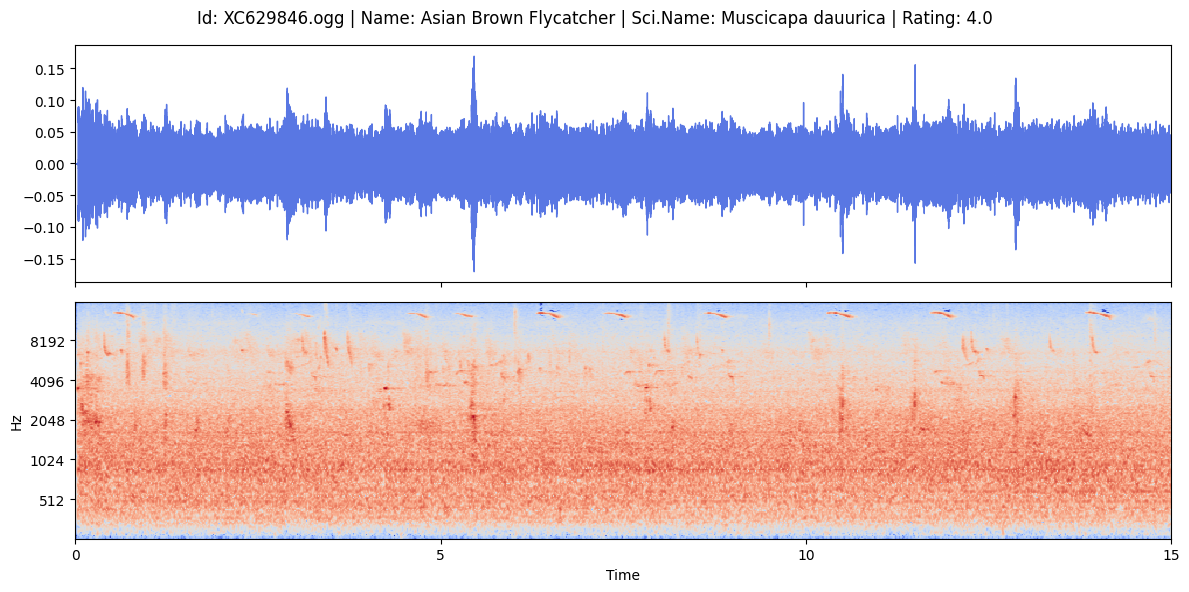

In [14]:
row = df.iloc[51]

# Display audio
display_audio(row)

# Data Split

In [15]:
# Import required packages
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.2)

print(f"Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

Num Train: 19567 | Num Valid: 4892


# Data Loaders


## Decoders

In [20]:
# Decodes Audio
def build_decoder(with_labels=True, dim=1024):
    def get_audio(filepath):
        def _load_audio(path):
            # Decode the filepath from bytes to string
            path = path.numpy().decode('utf-8') if isinstance(path, tf.Tensor) else path
            # Load audio with librosa
            audio, _ = librosa.load(path, sr=CFG.sample_rate, mono=True)
            return audio.astype(np.float32)

        # Use tf.py_function to wrap the librosa call
        audio = tf.py_function(_load_audio, [filepath], tf.float32)
        audio.set_shape([None])  # Set shape for TensorFlow graph
        return audio
    def crop_or_pad(audio, target_len, pad_mode="constant"):
        audio_len = tf.shape(audio)[0]
        diff_len = abs(
            target_len - audio_len
        )  # find difference between target and audio length
        if audio_len < target_len:  # do padding if audio length is shorter
            pad1 = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
            pad2 = diff_len - pad1
            audio = tf.pad(audio, paddings=[[pad1, pad2]], mode=pad_mode)
        elif audio_len > target_len:  # do cropping if audio length is larger
            idx = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
            audio = audio[idx : (idx + target_len)]
        return tf.reshape(audio, [target_len])

    def apply_preproc(spec):
        # Standardize
        mean = tf.math.reduce_mean(spec)
        std = tf.math.reduce_std(spec)
        spec = tf.where(tf.math.equal(std, 0), spec - mean, (spec - mean) / std)

        # Normalize using Min-Max
        min_val = tf.math.reduce_min(spec)
        max_val = tf.math.reduce_max(spec)
        spec = tf.where(
            tf.math.equal(max_val - min_val, 0),
            spec - min_val,
            (spec - min_val) / (max_val - min_val),
        )
        return spec

    def get_target(target):
        target = tf.reshape(target, [1])
        target = tf.cast(tf.one_hot(target, CFG.num_classes), tf.float32)
        target = tf.reshape(target, [CFG.num_classes])
        return target

    def decode(path):
        # Load audio file
        audio = get_audio(path)
        # Crop or pad audio to keep a fixed length
        audio = crop_or_pad(audio, dim)
        # Audio to Spectrogram
        spec = keras.layers.MelSpectrogram(
            num_mel_bins=CFG.img_size[0],
            fft_length=CFG.nfft,
            sequence_stride=CFG.hop_length,
            sampling_rate=CFG.sample_rate,
        )(audio)
        # Apply normalization and standardization
        spec = apply_preproc(spec)
        # Spectrogram to 3 channel image (for imagenet)
        spec = tf.tile(spec[..., None], [1, 1, 3])
        spec = tf.reshape(spec, [*CFG.img_size, 3])
        return spec

    def decode_with_labels(path, label):
        label = get_target(label)
        return decode(path), label

    return decode_with_labels if with_labels else decode

##Augmenters

In [21]:
def build_augmenter():
    augmenters = [
        keras_cv.layers.MixUp(alpha=0.4),
        keras_cv.layers.RandomCutout(height_factor=(1.0, 1.0),
                                     width_factor=(0.06, 0.12)), # time-masking
        keras_cv.layers.RandomCutout(height_factor=(0.06, 0.1),
                                     width_factor=(1.0, 1.0)), # freq-masking
    ]

    def augment(img, label):
        data = {"images":img, "labels":label}
        for augmenter in augmenters:
            if tf.random.uniform([]) < 0.35:
                data = augmenter(data, training=True)
        return data["images"], data["labels"]

    return augment

## Data Pipeline

In [22]:
def build_dataset(paths, labels=None, batch_size=32,
                  decode_fn=None, augment_fn=None, cache=True,
                  augment=False, shuffle=2048):

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None, dim=CFG.audio_len)

    if augment_fn is None:
        augment_fn = build_augmenter()

    AUTO = tf.data.experimental.AUTOTUNE
    slices = (paths,) if labels is None else (paths, labels)
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache() if cache else ds
    if shuffle:
        opt = tf.data.Options()
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

## Build Train and Valid Dataloaders

In [23]:
# Train
train_paths = train_df.filepath.values
train_labels = train_df.target.values
train_ds = build_dataset(train_paths, train_labels, batch_size=CFG.batch_size,
                         shuffle=True, augment=CFG.augment)

# Valid
valid_paths = valid_df.filepath.values
valid_labels = valid_df.target.values
valid_ds = build_dataset(valid_paths, valid_labels, batch_size=CFG.batch_size,
                         shuffle=False, augment=False)

# Visualization

In [24]:
def plot_batch(batch, row=3, col=3, label2name=None,):
    """Plot one batch data"""
    if isinstance(batch, tuple) or isinstance(batch, list):
        specs, tars = batch
    else:
        specs = batch
        tars = None
    plt.figure(figsize=(col*5, row*3))
    for idx in range(row*col):
        ax = plt.subplot(row, col, idx+1)
        lid.specshow(np.array(specs[idx, ..., 0]),
                     n_fft=CFG.nfft,
                     hop_length=CFG.hop_length,
                     sr=CFG.sample_rate,
                     x_axis='time',
                     y_axis='mel',
                     cmap='coolwarm')
        if tars is not None:
            label = tars[idx].numpy().argmax()
            name = label2name[label]
            plt.title(name)
    plt.tight_layout()
    plt.show()

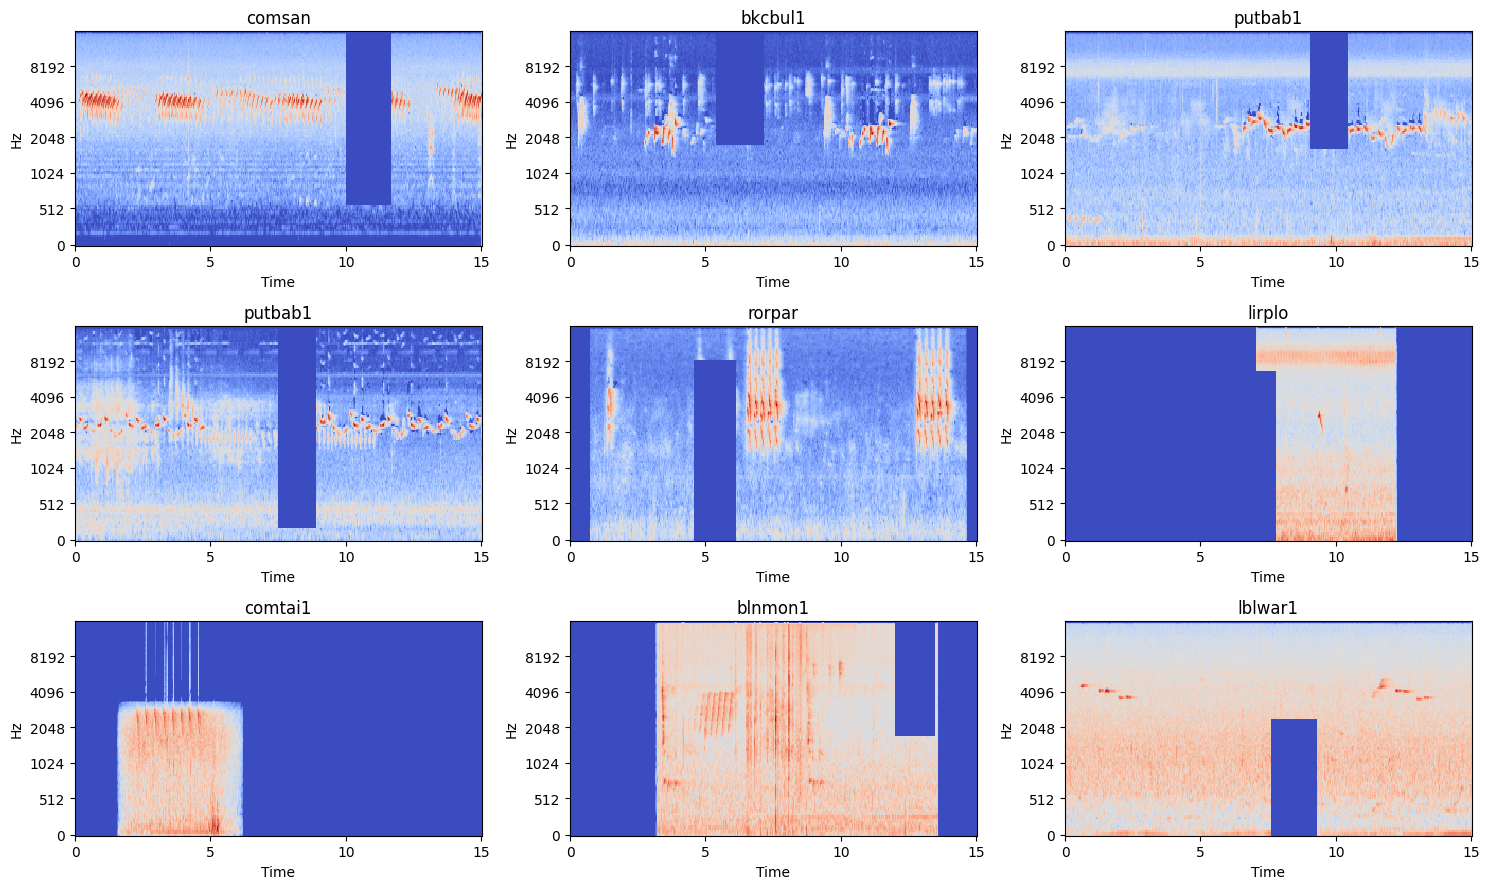

In [25]:
sample_ds = train_ds.take(100)
batch = next(iter(sample_ds))
plot_batch(batch, label2name=CFG.label2name)